In [1]:
from sklearn import svm
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [2]:
#General Imports
import csv
import math
import matplotlib.pyplot as plt
import pylab as pl

#ScikitLearn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split

#Qiskit imports
from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [3]:
# Constants
SEED = 2508


In [4]:
from qiskit import IBMQ
from qiskit.visualization import plot_error_map

In [5]:
# IBMQ.save_account('YOUR TOKEN HERE')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education',group='qscitech-quantum',project='qc-bc-workshop')

IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

In [ ]:
ibmq_jakarta = provider.get_backend('ibmq_jakarta')
plot_error_map(ibmq_jakarta)

# 1. Prepare Dataset

**Dataset Information:**
* Total examples: 1372 -- Dimensions: 5
* Training set [to train a model]: 
* (Validation set [to benchmark different models and choose the best performer]):
* Test set [to test actual performance of the best performer following validation]:

In [5]:
datafile = pd.read_csv("banknote_auth_full.txt",header=0)
datafile

,3.6216,8.6661,-2.8073,-0.44699,0
0,4.54590,8.16740,-2.4586,-1.46210,0
1,3.86600,-2.63830,1.9242,0.10645,0
2,3.45660,9.52280,-4.0112,-3.59440,0
3,0.32924,-4.45520,4.5718,-0.98880,0
4,4.36840,9.67180,-3.9606,-3.16250,0
...,...,...,...,...,...
1366,0.40614,1.34920,-1.4501,-0.55949,1
1367,-1.38870,-4.87730,6.4774,0.34179,1
1368,-3.75030,-13.45860,17.5932,-2.77710,1
1369,-3.56370,-8.38270,12.3930,-1.28230,1


In [6]:
data = datafile.to_numpy()
print(f'{data.shape} -- {data.shape[0]} examples ; {data.shape[1]} features')
# TODO: split the dataset to: Training set (100 points only), (Validation set), Test set
# TODO: might need to scale (or, normalize) the features -- explanation: in gradient-based ML, we want all features to be
# at the same scale (e.g., all between [-1,1]) to optimize learning performance.
# Here, we have features 1 and 2 can have value upto +/-20, which is very large compared to other features --> need scaling

(100, 5) -- 100 examples ; 5 features


In [6]:
datafile_100 = pd.read_csv("banknote_auth_full.txt",header=0)
datafile_100

,3.6216,8.6661,-2.8073,-0.44699,0
0,4.54590,8.16740,-2.4586,-1.46210,0
1,3.86600,-2.63830,1.9242,0.10645,0
2,3.45660,9.52280,-4.0112,-3.59440,0
3,0.32924,-4.45520,4.5718,-0.98880,0
4,4.36840,9.67180,-3.9606,-3.16250,0
...,...,...,...,...,...
1366,0.40614,1.34920,-1.4501,-0.55949,1
1367,-1.38870,-4.87730,6.4774,0.34179,1
1368,-3.75030,-13.45860,17.5932,-2.77710,1
1369,-3.56370,-8.38270,12.3930,-1.28230,1


In [7]:
data_100 = datafile_100.to_numpy()
print(f'{data_100.shape} -- {data_100.shape[0]} examples ; {data_100.shape[1]} features')

(1371, 5) -- 1371 examples ; 5 features


In [8]:
xdata_100, ydata_100 = np.hsplit(data_100, [4])
feature_dim=np.shape(xdata_100)[1]
print(f'{feature_dim} number of features')
xdata_100
ydata_100
print(f'{xdata_100.shape} -- {ydata_100.shape}')

4 number of features
(1371, 4) -- (1371, 1)


In [9]:
test_ratio=0.9
seed=2456

In [10]:
x_train, x_test, y_train, y_test = train_test_split(xdata_100, ydata_100, test_size=test_ratio, random_state=seed)
print(f'{x_train.shape} -- {y_train.shape}')
print(f'{x_test.shape} -- {y_test.shape}')
#x_train[4]
print(y_train[4])
y_train = np.reshape(y_train, -1)
print(y_train[1])
y_test = np.reshape(y_test, -1)
#print(x_train[4])

(137, 4) -- (137, 1)
(1234, 4) -- (1234, 1)
[0.]
0.0


In [28]:
y_train

array([1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       0.])

# 2. VQC from scratch

## 2.1. Prepare encoders and ansatz

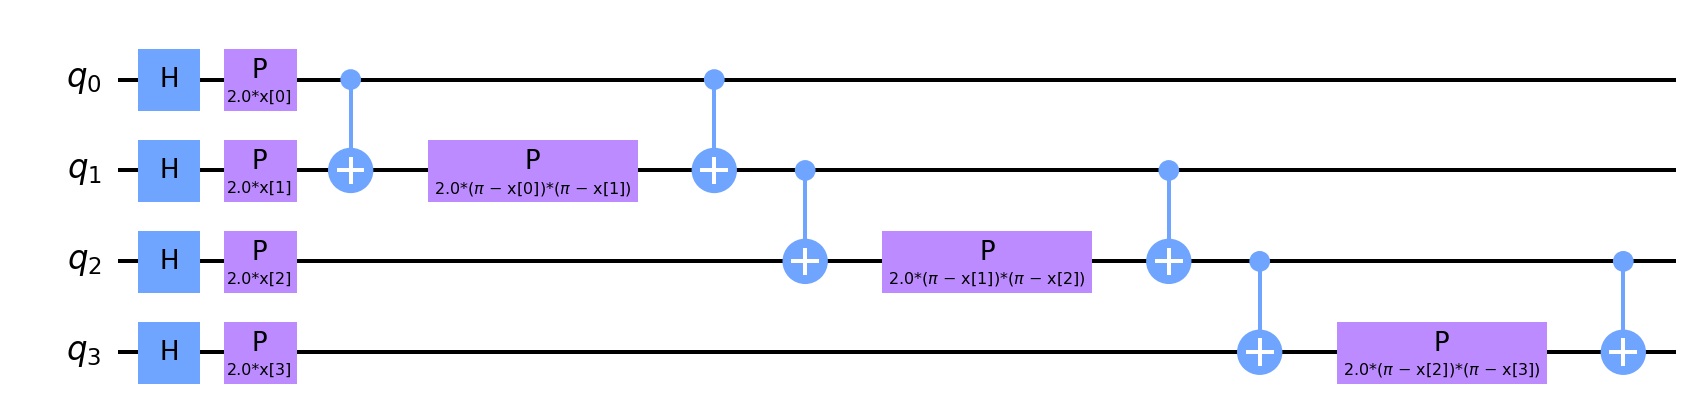

In [51]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(feature_dim, 1, 'linear')
fmap_zz.decompose().draw('mpl', scale=2)

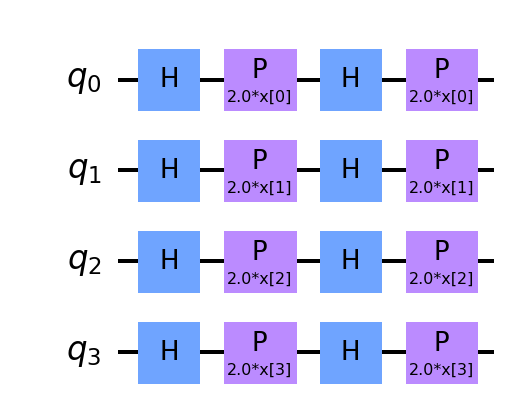

In [32]:
def get_z_feature_map(feature_dim, feature_map_rep):
    return ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep)

fmap_z = get_z_feature_map(feature_dim, 2)
fmap_z.decompose().draw('mpl', scale=2)

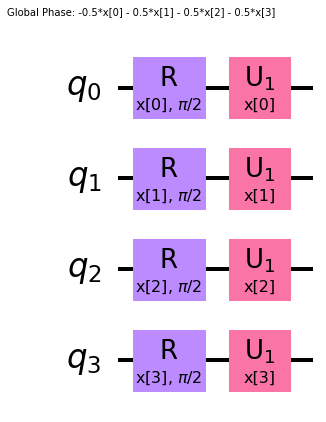

In [61]:
def get_my_map(feature_dim, feature_map_rep):
    
    data_params = ParameterVector('x', 4)
    
    model_circuit = QuantumCircuit(4)
    ### Let's code here
    
    for l in range(0,feature_map_rep):
        model_circuit.ry(data_params[0],0)
        model_circuit.ry(data_params[1],1)
        model_circuit.ry(data_params[2],2)
        model_circuit.ry(data_params[3],3)
        
        
        model_circuit.rz(data_params[0],0)
        model_circuit.rz(data_params[1],1)
        model_circuit.rz(data_params[2],2)
        model_circuit.rz(data_params[3],3)
       
        


    ###
    
    return model_circuit


mymap = get_my_map(feature_dim, 1)
mymap.decompose().draw('mpl', scale=2)

In [12]:
# Define function(s) to generate the encoder circuit
# TODO: implement different designs for data encoding (one function for each)
def encoder_circuit_1(data_x,_):
    """
    Args:
        data_x [np.array] : one data example
        (...)
    Returns:
        encoder_circuit [QuantumCircuit] : encoder circuit for input data example
    """
    encoder_circuit = None
    return encoder_circuit

## 2.2. Prepare Ansatz

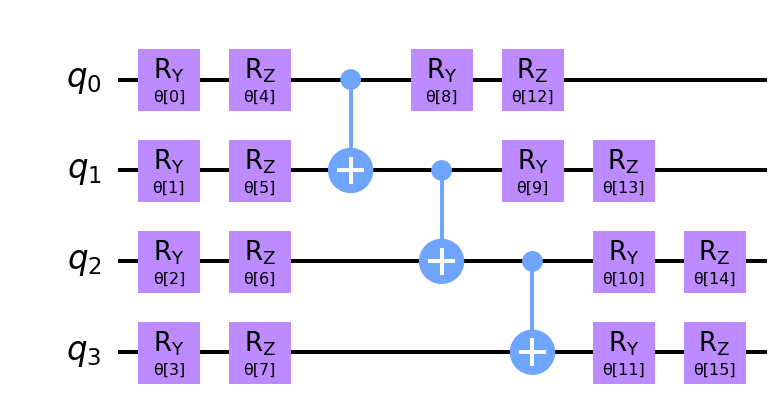

In [13]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(feature_dim, ['ry', 'rz'], 1, 'linear')
ansatz_tl.decompose().draw('mpl', scale=2)

In [14]:
# Define function(s) to generate the ansatz
# TODO: implement different ansatz designs (one function for each)
def ansatz_1(n_qubits,_):
    """
    Args:
        n_qubits [int] : number of qubits in the circuit
        (...other necessary args -- e.g., n_layers)
    Returns:
        ansatz [QuantumCircuit] : parameterized ansatz circuit
        ansatz_params [ParameterVector] : parameter vector of the ansatz
    """
    ansatz = None
    ansatz_params = None
    return ansatz, ansatz_params

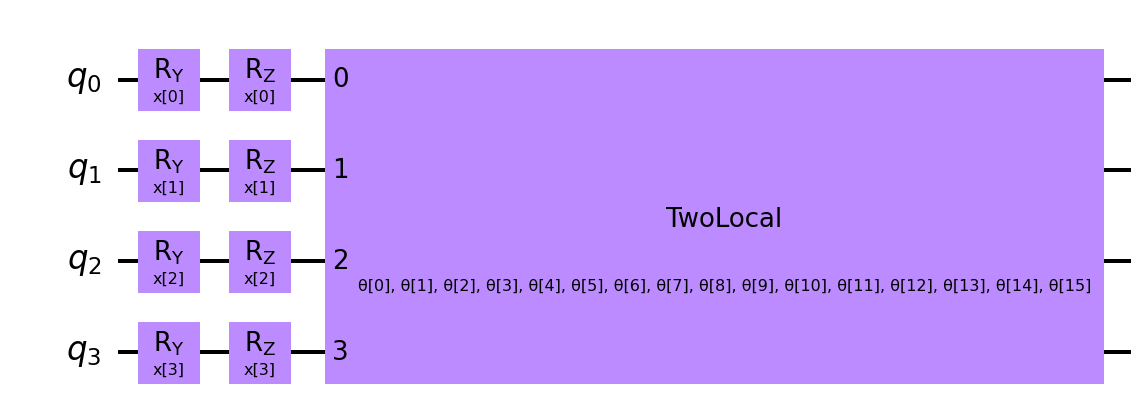

In [62]:
#var_circuit = fmap_zz.compose(ansatz_tl)
#var_circuit = fmap_z.compose(ansatz_tl)
var_circuit = mymap.compose(ansatz_tl)
var_circuit.draw('mpl',scale=2)

In [19]:
# TODO: Define function to generate all data encoder circuits (one for each example in the dataset)
# Preparing and cache all encoder circuits to concatenate with ansatz later
def get_all_encoders(data_mat, encoder_func,_):
    """
    Args:
        data_mat [np.array] : of shape (n_samples,n_features) -- matrix containing all examples
        encoder_func [function] : callable to generate encoder circuit (e.g., encoder_circuit_1)
        (...)
    Returns:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
    """
    all_encoders = []
    # pseudo-code: for 'example' in 'data_mat': all_encoders.append(encoder_func('example'))
    return all_encoders

In [20]:
# TODO: Define function to generate all VQC circuits (one for each example)
def get_all_circuits(all_encoders, ansatz_func, _):
    """
    Args:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
        ansatz_func [function] : callable to generate ansatz circuit (e.g., ansatz_1)
        (...)
    Returns:
        all_circuits [list(QuantumCircuit)] : list of all VQC circuits (one for each example)
    """
    all_circuits = []
    return all_circuits

In [38]:
# Create a quantum instance to wrap the execution of circuits
qinstVQC = QuantumInstance(Aer.get_backend('statevector_simulator'))
# or, real hardware backend qinst = ....

In [22]:
# TODO: Define function to calculate target values (can be expectation value or sampling probability)
def get_all_target_vals(all_results,_):
    """
    Args:
        all_results [Result] : output wrapper of all results from executing the VQC circuits
        (...)
    Returns:
        target_val [list(float)] : target values for classification (e.g., expectation value), one for each example
    """
    target_vals = []
    return target_vals

In [23]:
# TODO: Define function to calculate cost function given all target vals (there can be multiple designs for cost function)
def calculate_cost_function(target_vals,true_labels,_):
    """
    Args:
        target_vals [list(float)] : target values for classification (e.g., expectation value), one for each example
        true_labels [np.array] : vector containing true labels for each example (0 or 1)
        (...)
    Returns:
        cost [float] : total cost for current instance
    """
    cost = 0
    return cost

## 2.3 Prepare measurement

In [19]:
# for multi-class problem this works
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes


# for multi-class problem this needs to be changed
def one_qubit_binary(x):
    return x % 2

## 2.2. Training Implementation

In [20]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP, ADAM

In [ ]:
# TODO: Define training wrapper 
# TODO: Run optimization and plot loss curve
# (...)

## 2.3. Results Discussion

e.g., what method worked best, what did we learn about the problem?

# 3. VQC using Qiskit QNN Classes

In [39]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst_qasm = QuantumInstance(qasm_sim, 2048)

## 3.1. Circuit QNN

In [178]:
fmap_z.parameters

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3])])

In [63]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 #input_params=fmap_z.parameters,
                 #input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                 input_params=mymap.parameters,                                  # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst_qasm)

### Forward pass

In [58]:
# The result of the neural network of the shape (output_shape).
weights = np.random.random(len(ansatz_tl.parameters))

output = qnn.forward(x_train[1], weights)
print(output.shape)
output

(1, 2)


array([[0.58886719, 0.41113281]])

### Backward pass

In [42]:
_, update = qnn.backward(x_train[0], weights)
print(update)
print(update.shape)

[[[ 4.10644531e-01  9.76562500e-04 -2.44140625e-03 -1.46484375e-03
   -1.20361328e-01 -8.66699219e-02 -1.95312500e-03  1.46484375e-03
    2.52929688e-01  2.44140625e-04 -1.34277344e-02 -7.32421875e-04
   -6.10351563e-03 -5.12695313e-03 -2.44140625e-04  6.59179687e-03]
  [-4.10644531e-01 -9.76562500e-04  2.44140625e-03  1.46484375e-03
    1.20361328e-01  8.66699219e-02  1.95312500e-03 -1.46484375e-03
   -2.52929688e-01 -2.44140625e-04  1.34277344e-02  7.32421875e-04
    6.10351562e-03  5.12695313e-03  2.44140625e-04 -6.59179687e-03]]]
(1, 2, 16)


### 3.1.1. Prepare encoder, ansatz, and interpreter

In [53]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [95]:
print(y_train[0])
print(y_train_1h[0])

print(y_train[4])
print(y_train_1h[4])

1.0
[0. 1.]
0.0
[1. 0.]


In [25]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

### 3.1.2. Training Implementation

In [64]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(), #log of ...
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train]) # normalizing or not ... can depend on the data set you can try both

vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 128.82010609903728
6 - 125.54816363562153
9 - 124.6806356150212
12 - 118.17676552583133
15 - 112.2683271041748
18 - 111.75525702912807
21 - 107.00321139981949
24 - 106.94785221897195
27 - 105.39814926215539
30 - 105.20382668735863
33 - 105.17032773620139
36 - 102.8521201035623
39 - 102.73573834311935
42 - 102.01463013231034
45 - 102.03689702261175
48 - 100.15862179850001
51 - 100.32312146944139
54 - 99.75719616003158
57 - 99.70617473006618
60 - 99.22263045333335
63 - 99.44095531335982
66 - 98.80119093530999
69 - 98.37864851128018
72 - 98.52834665701401
75 - 97.88221598064003
78 - 97.99046119747759
81 - 98.33309442331904
84 - 98.6921692473581
87 - 98.25353682162196
90 - 98.07721599756097
93 - 98.24234630621869
96 - 97.42540781285973
99 - 97.0590208446335
102 - 97.51995138673004
105 - 97.31601912699145
108 - 97.31840616500217
111 - 96.69878348232199
114 - 96.57949798207756
117 - 95.95603586572159
120 - 96.15950469137968
123 - 95.67814322551637
126 - 96.2613374164643
129 - 95.64193308

In [65]:
score_train_norm = vqc.score(x_train_norm, y_train_1h)
print(f'Score on the normalized train set {score_train_norm}')

x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test]) # normalizing or not ... can depend on the data set you can try both
score_test_norm = vqc.score(x_test_norm, y_test_1h)
print(f'Score on the normalized test set {score_test_norm}')

Score on the normalized train set 0.8978102189781022
Score on the normalized test set 0.8816855753646677


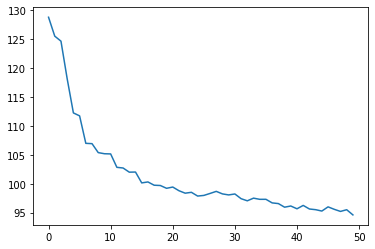

In [66]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

## 3.2. Opflow QNN

### 3.2.1. Define measurement operator and circuit state function

In [64]:
from qiskit.opflow import StateFn, Gradient, I, Z

In [65]:
obs_parity = Z ^ feature_dim
obs_one_qubit = I ^ (feature_dim - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIZ'), coeff=1.0)

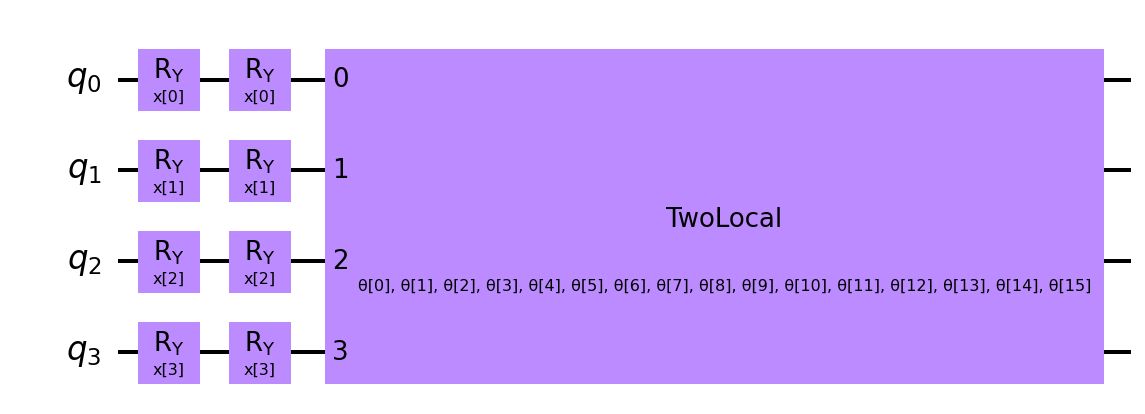

In [66]:
#fmap_z_op = get_z_feature_map(feature_dim, 3)
#var_circuit_op = fmap_z_op.compose(ansatz_tl)

#fmap_zz_op = get_zz_feature_map(feature_dim, 3)
#var_circuit_op = fmap_zz_op.compose(ansatz_tl)

mymap_op = get_my_map(feature_dim, 2)
var_circuit_op = mymap_op.compose(ansatz_tl)


var_circuit_op.draw('mpl',scale=2)

In [67]:
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit_op)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002034FA53610>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [68]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(operator,
                   #input_params=fmap_z_op.parameters,
                   input_params=mymap_op.parameters,
                   weight_params=ansatz_tl.parameters,
                   gradient=gradient,
                   quantum_instance=qinst_qasm)

### Forward pass

In [69]:
weights = np.random.random(len(ansatz_tl.parameters))
output = op_qnn.forward(x_train[0], weights)
print(output.shape)

(1, 1)


### Backward pass

In [64]:
_, update = op_qnn.backward(x_train[0], weights)
print(update.shape)
update

(1, 1, 16)


array([[[-0.46582031, -0.00732422, -0.00390625,  0.01757813,
          0.04003906,  0.00878906, -0.01855469,  0.00830078,
         -0.83789062,  0.02880859,  0.00732422,  0.01318359,
         -0.00683594, -0.01318359, -0.00244141, -0.01220703]]])

### 3.1.2. Training Implementation

In [70]:
from qiskit.algorithms.optimizers import GradientDescent

In [71]:
y_train_pm = np.array([-1 if y==0 else y for y in y_train])
y_test_pm = np.array([-1 if y==0 else y for y in y_test])
y_train.shape

(80,)

In [72]:
max_itr = 30
gd_opt = GradientDescent(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
op_vqc = NeuralNetworkClassifier(neural_network=op_qnn,
                                 loss=L2Loss(),
                                 one_hot=False,
                                 optimizer=gd_opt,
                                 initial_point=initial_point)

op_vqc = op_vqc.fit(x_train, y_train_pm)

1 - 109.27603054046631
2 - 108.25804901123047
3 - 106.33079814910889
4 - 104.87362766265869
5 - 101.9281587600708
6 - 97.71057415008545
7 - 90.23495197296143
8 - 83.41075992584229
9 - 80.60181045532227
10 - 79.26840400695801
11 - 79.95791816711426
12 - 80.30300807952881
13 - 80.20854091644287
14 - 79.80421257019043
15 - 79.60912609100342
16 - 79.73513221740723
17 - 79.49081230163574
18 - 79.88297939300537
19 - 79.32025814056396
20 - 80.02000522613525
21 - 79.58462333679199
22 - 78.97389793395996
23 - 79.08813285827637
24 - 79.29561614990234
25 - 79.15980339050293
26 - 79.86717987060547
27 - 78.74774742126465
28 - 79.38510417938232
29 - 78.82346248626709
30 - 79.52055835723877


In [73]:
score_train = op_vqc.score(x_train, y_train_pm)
score_test = op_vqc.score(x_test, y_test_pm)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5125
Score on the test set 0.65


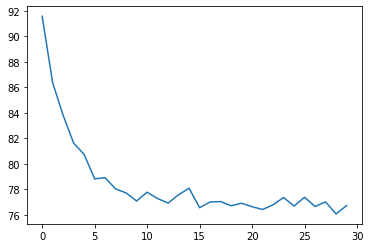

In [50]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

# 4. Quantum Support Vector Machine (if have time)

## 4.1. Define feature map(s) (kernel)

## 4.2. Prepare all circuits and obtain kernel matrix

## 4.3. Training Implementation (using sci-kit's SVC class)

## 4.4. Results Discussion

# 5. Classical Methods (if have time)

## 5.1. Classical SVM

## 5.2. Classical Neural Network

# 5. Summary & Conclusion

Summarize and reflect on all aspects and observations of the project. Did we end up with a decent classifier?